In [8]:
%%file FDM_Vanilla.m
% Vanilla Option Pricing (FDM)

function[Price, f] = FDM_Vanilla(Style, C_P, Method, S, X, r, T, vol, q, Smax, M, N, GP)
    
    %격자구성
    dS     = Smax / M;         %주가가격 설정
    grid_S = [Smax:-dS:0];     %주가노드 구성
    dt     = T/N;
    grid_T = T:-dt:0;           %시간노드 구성
    grid_i = 0:1:N;            %첨자(시점)
    grid_j = M:-1:0;           %첨자(주가위치)
    f      = zeros(M+1, N+1);  %노드별 옵션가치 저장행렬
    
    %경계조건
    if C_P == 'C'
        f(:, N+1) = max(grid_S - X, 0);   %Terminal BC
        f(1, :)   = Smax - X * exp(-r*dt*(N-grid_i));     %Upper BC
        f(M+1, :) = 0;    % Lower BC
    elseif C_P == 'P'
        f(:, N+1) = max(X - grid_S, 0);
        f(1, :)   = 0;
        f(M+1, :) = X*exp(-r*dt*(N-grid_i));
    end
    
    %각 방법별 계수행렬 계산
    %Explicit(EXP), Implicit(IMP), Crank-Nicolson(CN)
    switch Method
        case 'EXP'
            df = 1/(1+r*dt);
            Exp_a = df * (-0.5*(r-q)*grid_j*dt + 0.5*vol^2*(grid_j.^2)*dt);
            Exp_b = df * (1 - vol^2*(grid_j.^2)*dt);
            Exp_c = df * ( 0.5*(r-q)*grid_j*dt + 0.5*vol^2*(grid_j.^2)*dt);
        case 'IMP'
            Imp_a =  0.5*(r-q)*grid_j*dt - 0.5*vol^2*(grid_j.^2)*dt;
            Imp_b = 1 + vol^2*(grid_j.^2)*dt + r*dt;
            Imp_c = -0.5*(r-q)*grid_j*dt - 0.5*vol^2*(grid_j.^2)*dt;
        case 'CN'
            CN_a  = 0.25*dt*(vol^2*(grid_j.^2) - (r-q)*grid_j);
            CN_b  = -0.5*dt*(vol^2*(grid_j.^2) + r);
            CN_c  = 0.25*dt*(vol^2*(grid_j.^2) + (r-q)*grid_j);
    end
    
    switch Method
        case 'EXP'
            for h=N:-1:1
                for k=2:M
                    if Style == 'EU'
                        f(k, h) = Exp_a(k) * f(k+1, h+1) + Exp_b(k) * f(k, h+1) + Exp_c(k) * f(k-1, h+1);
                    elseif Style == 'AM'
                        f(k, h) = Exp_a(k) * f(k+1, h+1) + Exp_b(k) * f(k, h+1) + Exp_c(k) * f(k-1, h+1);
                        if C_P == 'C'
                            f(k, h) = max(f(k, h), grid_S(k) - X);
                        elseif C_P == 'P'
                            f(k, h) = max(f(k, h), X - grid_S(k));
                        end
                    end
                end
            end
        %선형보간법으로 현재주가에 대응되는 옵션가치 산출
        Price = interp1(grid_S, f(:,1), S, 'linear');
        case 'IMP'
            %Tridigonal 계수행렬 생성
            Coeff  = diag(Imp_c(3:M), -1) + diag(Imp_b(2:M)) + diag(Imp_a(2:M-1), 1);
            [L, U] = lu(Coeff);
            ca     = zeros(M-1, 1);
            for h = N:-1:1
                if Style == 'EU'
                    ca(1)     = Imp_c(2) * f(1, h);
                    ca(end)   = Imp_a(M) * f(M+1, h);
                    f(2:M, h) = inv(U) * (inv(L) * (f(2:M, h+1) - ca));
                elseif Style == 'AM'
                    ca(1)     = Imp_c(2) * f(1, h);
                    ca(end)   = Imp_a(M) * f(M+1, h);
                    f(2:M, h) = inv(U) * (inv(L)*(f(2:M, h+1) - ca));
                        if C_P == 'C'
                            f(2:M, h) = max(f(2:M, h), grid_S(2:M) - X);
                        elseif C_P == 'P'
                            f(2:M, h) = max(f(2:M, h), X - grid_S(2:M));
                        end
                end
            end
        Price = interp1(grid_S, f(:, 1), S, 'linear');
        case 'CN'
            %Traditional 계수행렬 생성(ML : 좌변 계수행렬, MR : 우변 계수행렬)
            ML = diag(-CN_c(3:M), -1) + diag(1 - CN_b(2:M)) + diag(-CN_a(2:M-1), 1);
            [L, U] = lu(ML);
            MR = diag(CN_c(3:M), -1)  + diag(1 + CN_b(2:M)) + diag(CN_a(2:M-1), 1);
            ca = zeros(M-1, 1);
            for h = N:-1:1
                if Style == 'EU'
                    ca(1)     = CN_c(2) * (f(1, h)   + f(1, h+1));
                    ca(end)   = CN_a(M) * (f(M+1, h) + f(M+1, h+1));
                    f(2:M, h) = inv(U)  * (inv(L) * (MR*f(2:M, h+1) + ca));
                elseif Style == 'AM'
                    ca(1)     = CN_c(2) * (f(1, h) + f(1, h+1));
                    ca(end)   = CN_a(M) * (f(M+1, h) + f(M+1, h+1));
                    f(2:M, h) = inv(U)  * (inv(L) * (MR * f(2:M, h+1) + ca));
                        if C_P == 'C'
                            f(2:M, h) = max(f(2:M, h), grid_S(2:M) - X);
                        elseif C_P == 'P'
                            f(2:M, h) = max(f(2:M, h), X - grid_S(2:M));
                        end
                end
            end
        Price = interp1(grid_S, f(:, 1), S, 'linear');
    end
    
    %잔존만기와 주가변화에 따른 옵션가격 그래프
    if GP == 1
        [grid_T, grid_S] = meshgrid(grid_T, grid_S);
        mesh(grid_T, grid_S, f)
        xlabel('Time to Maturity');
        ylabel('Stock Price');
        zlabel('Option Price');
        title('FDM Vanilla Option Price')
    end
        
        
    

Created file '/Users/changsoo/Desktop/논문/Matlab/FDM_Vanilla.m'.


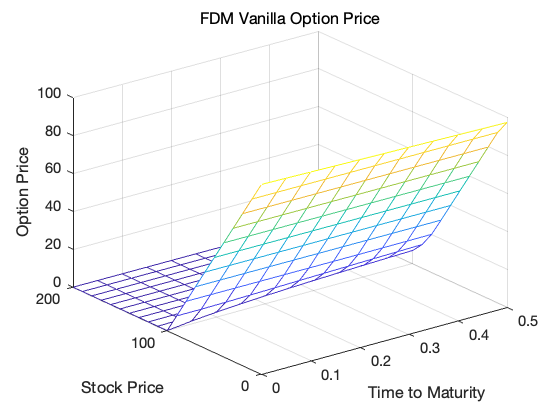

In [12]:
[FDM_Price, f] = FDM_Vanilla('AM', 'P', 'IMP', 100, 100, 0.05, 0.5, 0.3, 0.01, 200, 20, 10, 1);

In [13]:
FDM_Price


FDM_Price =

    7.1415



In [14]:
f


f =

  1 ~ 7번 열

         0         0         0         0         0         0         0
    0.0128    0.0088    0.0058    0.0035    0.0020    0.0010    0.0004
    0.0312    0.0219    0.0146    0.0092    0.0053    0.0028    0.0013
    0.0637    0.0460    0.0317    0.0206    0.0124    0.0068    0.0033
    0.1262    0.0942    0.0673    0.0456    0.0288    0.0166    0.0085
    0.2501    0.1936    0.1441    0.1022    0.0680    0.0416    0.0227
    0.4978    0.4006    0.3117    0.2322    0.1636    0.1069    0.0629
    0.9921    0.8319    0.6781    0.5329    0.3993    0.2802    0.1793
    1.9645    1.7183    1.4702    1.2225    0.9784    0.7426    0.5220
    3.8163    3.4817    3.1292    2.7574    2.3655    1.9538    1.5249
    7.1415    6.7762    6.3807    5.9479    5.4681    4.9275    4.3060
   12.5579   12.2955   12.0220   11.7362   11.4371   11.1262   10.8109
   20.2326   20.1447   20.0724   20.0215   20.0000   20.0000   20.0000
   30.0000   30.0000   30.0000   30.0000   30.0000   30.000

In [1]:
%%file FDM_KnockOut.m
% KnockOut Option Pricing(FDM)
function[Price, f] = FDM_KnockOut(Style, C_P, KO, Method, S, X, B, r, T, vol, q, Smax, M, N, GP)
    %격자 구성
    if KO == 'U'        %Up and Out Barrier 설정
        Smax   = B; dS = Smax / M;
        grid_S = [Smax:-dS:0]'; dt = T/N;
        grid_T = [T:-dt:0];
        grid_i = 0:1:N;
        grid_j = M:-1:0;
    elseif KO == 'D'    %Down and Out Barrier 설정
        Smax   = Smax; dS = (Smax - B) / M;
        grid_S = [Smax:-dS:B]'; dt = T/N;
        grid_T = [T:-dt:0];
        grid_i = 0:1:N;
        grid_j = grid_S / dS;       
    end
    
    f = zeros(M+1, N+1);
    
    %경계조건
    if C_P == 'C'
        f(:, N+1) = max(grid_S - X, 0);          %Terminal BC
            if KO == 'U'
                f(1, :) = 0;                     %Up and Out의 Upper BC
            elseif KO == 'D'
                f(1, :) = Smax - X*exp(-r*dt*(N - grid_i));    %Down and Out의 Upper BC
            end
        f(M+1, :) = 0;                           %Lower BC
    elseif C_P == 'P'
        f(:, N+1) = max(X-grid_S, 0);
        f(1, :)   = 0;
            if KO == 'U'
                f(M+1, :) = X*exp(-r*dt*(N - grid_i));
            elseif KO == 'D'
                f(M+1, :) = 0;
            end
    end
    
    %각 방법별 계수행렬 계산 (바닐라 옵션과 동일)
    switch Method
        case 'EXP'
            df = 1/(1+r*dt);
            Exp_a = df * (-0.5 * (r-q) * grid_j * dt + 0.5 * vol^2 * (grid_j.^2) * dt);
            Exp_b = df * (1 - vol^2 * (grid_j.^2) * dt);
            Exp_c = df * ( 0.5 * (r-q) * grid_j * dt + 0.5 * vol^2 * (grid_j.^2) * dt);
        case 'IMP'
            Imp_a = 0.5 * (r-q) * grid_j * dt - 0.5 * vol^2 * (grid_j.^2) * dt;
            Imp_b = 1 + vol^2 * (grid_j.^2) * dt + r*dt;
            Imp_c = -0.5 * (r-q) * grid_j * dt - 0.5 * vol^2 * (grid_j.^2) * dt;
        case 'CN'
            CN_a  = 0.25 * dt * (vol^2*(grid_j.^2) - (r-q) * grid_j);
            CN_b  = -0.5 * dt * (vol^2*(grid_j.^2) + r);
            CN_c  = 0.25 * dt * (vol^2*(grid_j.^2) + (r-q) * grid_j);
    end
    
    %연립차분방정식 풀이
    switch Method
        case 'EXP'
            for h=N:-1:1
                for k=2:M
                    if Style == 'EU'
                        f(k, h) = Exp_a(k) * f(k+1, h+1) + Exp_b(k) * f(k, h+1) + Exp_c(k) * f(k-1, h+1);
                    elseif Style == 'AM'
                        f(k, h) = Exp_a(k) * f(k+1, h+1) + Exp_b(k) * f(k, h+1) + Exp_c(k) * f(k-1, h+1);
                        if C_P  == 'C'
                            f(k, h) = max(f(k, h), grid_S(k) - X);
                        elseif C_P == 'P'
                            f(k, h) = max(f(k, h), X - grid_S(k));
                        end
                    end
                end
            end
        Price = interp1(grid_S, f(:, 1), S, 'linear');
        case 'IMP'
            Coeff  = diag(Imp_c(3:M), -1) + diag(Imp_b(2:M)) + diag(Imp_a(2:M - 1), 1);
            [L, U] = lu(Coeff);
            ca     = zeros(M-1, 1);
            
            for h = N:-1:1
                if Style == 'EU'
                    ca(1)     = Imp_c(2) * f(1, h);
                    ca(end)   = Imp_a(M) * f(M+1, h);
                    f(2:M, h) = inv(U) * (inv(L) * (f(2:M, h+1) - ca));
                    
                elseif Style == 'AM'
                    ca(1)     = Imp_c(2) * f(1, h);
                    ca(end)   = Imp_a(M) * f(M+1, h);
                    f(2:M, h) = inv(U) * (inv(L) * (f(2:M, h+1) - ca));
                        if C_P  == 'C'
                            f(2:M, h) = max(f(2:M, h), grid_S(2:M) - X);
                        elseif C_P == 'P'
                            f(2:M, h) = max(f(2:M, h), X - grid_S(2:M));
                        end
                end
            end
        Price = interp1(grid_S, f(:, 1), S, 'linear');
        case 'CN'
            ML = diag(-CN_c(3:M), -1) + diag(1-CN_b(2:M)) + diag(-CN_a(2:M - 1), 1);
            [L, U] = lu(ML);
            MR = diag(CN_c(3:M), -1)  + diag(1+CN_b(2:M)) + diag(CN_a(2:M-1), 1);
            ca = zeros(M-1, 1);
            for h= N:-1:1
                if Style == 'EU'
                    ca(1)     = CN_c(2) * (f(1, h)   + f(1, h+1));
                    ca(end)   = CN_a(M) * (f(M+1, h) + f(M+1, h+1));
                    f(2:M, h) = inv(U) * (inv(L) * (MR*f(2:M, h+1)+ca));
                elseif Style == 'AM'
                    ca(1)     = CN_c(2) * (f(1, h) + f(1, h+1));
                    ca(end)   = CN_a(M) * (f(M+1, h) +  f(M+1, h+1));
                    f(2:M, h) = inv(U) *  (inv(L) * (MR*f(2:M, h+1) +ca));
                        if C_P == 'C'
                            f(2:M, h) = max(f(2:M, h), grid_S(2:M) - X);
                        elseif C_P == 'P'
                            f(2:M, h) = max(f(2:M, h), X - grid_S(2:M));
                        end
                end
            end
        Price = interp1(grid_S, f(:, 1), S, 'linear');
    end
    
    %잔존만기와 주가변화에 따른 옵션가격 그래프 출력
    if GP == 1
        [grid_T, grid_S] = meshgrid(grid_T, grid_S);
        mesh(grid_T, grid_S, f)
        xlabel('Time to Maturity');
        ylabel('Stock Price');
        zlabel('Option Price');
        title('FDM Knock-Out Option Price');
    end
            

Created file '/Users/changsoo/Desktop/논문/Matlab/FDM_KnockOut.m'.



ans =

   5.7213e+77



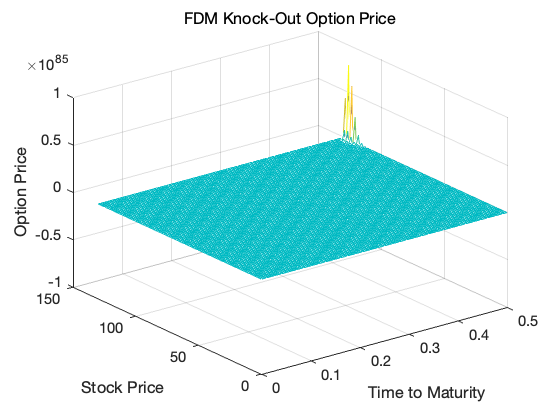

In [15]:
FDM_KnockOut('EU', 'C', 'U', 'EXP', 100, 100, 130, 0.05, 0.5, 0.3, 0.01, 200, 100, 100, 1)


ans =

    2.8299



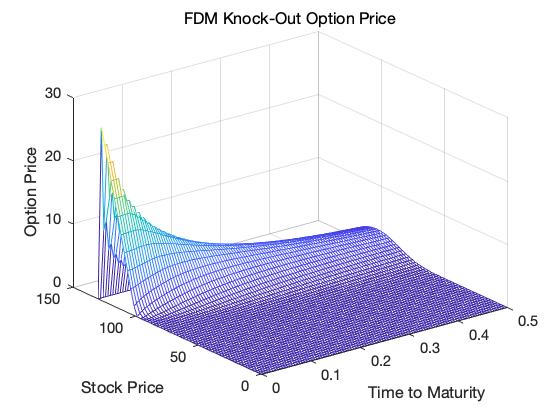

In [16]:
FDM_KnockOut('EU', 'C', 'U', 'EXP', 100, 100, 130, 0.05, 0.5, 0.3, 0.01, 200, 50, 100, 1)


ans =

    2.8544



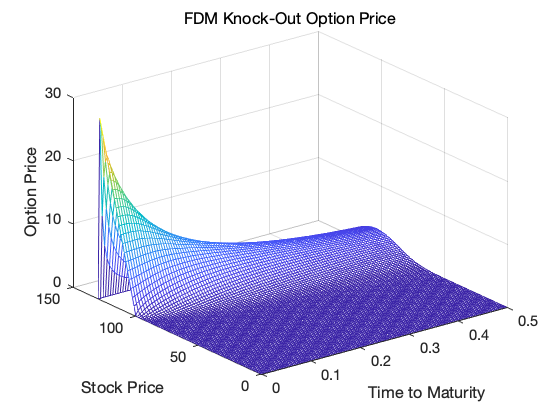

In [17]:
FDM_KnockOut('EU', 'C', 'U', 'IMP', 100, 100, 130, 0.05, 0.5, 0.3, 0.01, 200, 100, 100, 1)


ans =

    2.8447



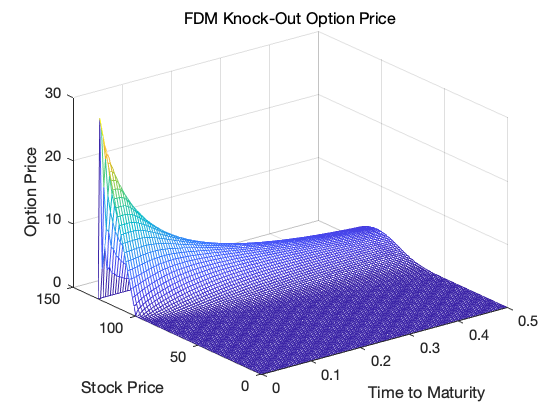

In [18]:
FDM_KnockOut('EU', 'C', 'U', 'CN', 100, 100, 130, 0.05, 0.5, 0.3, 0.01, 200, 100, 100, 1)